### Author: William C Francis (willcf)
##Solution 2
### (i)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


####Downloading the dataset

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

### Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [3]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14

In [4]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing 

In [5]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

### Creating dataloaders

In [6]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=False, batch_size=100)

###(ii)
### Variational Auto Encoder model

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

### Defining loss, optimizer and LR scheduler

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, ERR, KLD

### Training and Validating

In [9]:
count=0
n_wu, testl, update, erre, klde = [], [], [], [], []
for epoch in range(1, 100):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        err_l, kld_l = [], []
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/len(data))
        kld_l.append(kld.item()/len(data))
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)
    erre.append(sum(err_l)/len(err_l))
    klde.append(sum(kld_l)/len(kld_l))

    scheduler.step(train_loss / len(trainloader.dataset))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld
    
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
PATH = 'weights/model_state.pth'
torch.save(model.state_dict(), PATH)


====> Epoch: 1 Average loss: 52.9656
====> Test set loss: 42.5956
====> Epoch: 2 Average loss: 40.1951
====> Test set loss: 38.0567
====> Epoch: 3 Average loss: 37.7370
====> Test set loss: 36.8617
====> Epoch: 4 Average loss: 36.6717
====> Test set loss: 36.1645
====> Epoch: 5 Average loss: 35.9590
====> Test set loss: 35.5022
====> Epoch: 6 Average loss: 35.3961
====> Test set loss: 35.1887
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
====> Epoch: 7 Average loss: 34.9230
====> Test set loss: 34.7167
====> Epoch: 8 Average loss: 34.2999
====> Test set loss: 34.4666
====> Epoch: 9 Average loss: 34.1538
====> Test set loss: 34.3072
====> Epoch: 10 Average loss: 33.9546
====> Test set loss: 34.0656
====> Epoch: 11 Average loss: 33.7782
====> Test set loss: 34.1454
====> Epoch: 12 Average loss: 33.6959
====> Test set loss: 33.7432
Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
====> Epoch: 13 Average loss: 33.5602
====> Test set loss: 33.6633
====> Epoch: 1

### (iii) Plotting the first and second term of ELBO as a function of weight updates

In [10]:
x = [i+1 for i in range(99)]
len(x)



99

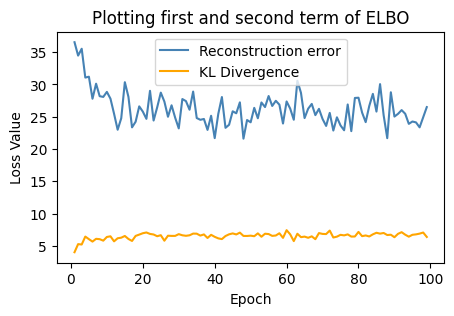

In [11]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(x, erre, 'steelblue', label='Reconstruction error')
plt.plot(x, klde, 'orange', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
    

### (iv) 
### Visualizing input and output from the VAE from training set

In [8]:
model.eval()
for i in range(8):
  a,t = next(iter(trainloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(a[0].detach().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
  axarr[0].set_title("Original Image")
  axarr[0].axis("off")

  axarr[1].imshow(b.detach().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
  axarr[1].set_title("Reconstructed Image")
  axarr[1].axis("off")
  
  plt.show()

NameError: name 'model' is not defined

### Visualizing input and output of the VAE from validation set

In [29]:
len(testloader)

10

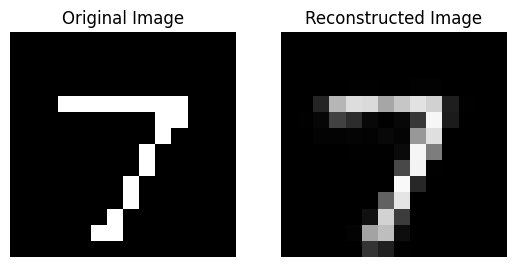

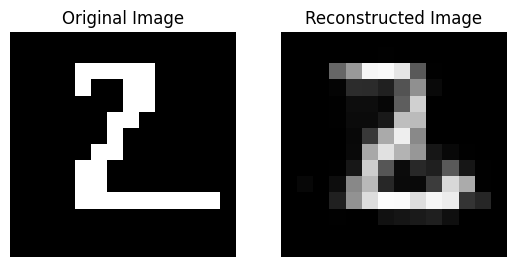

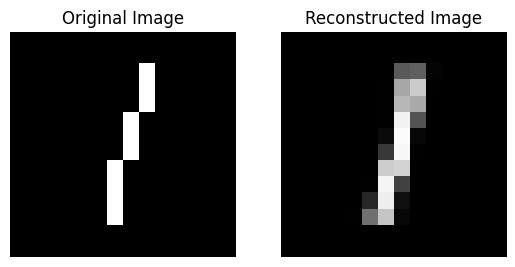

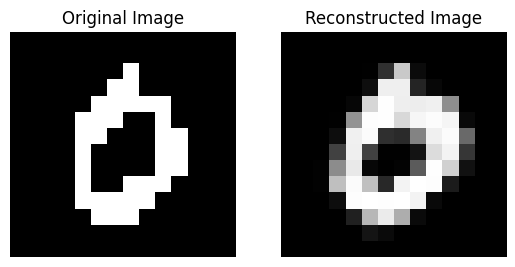

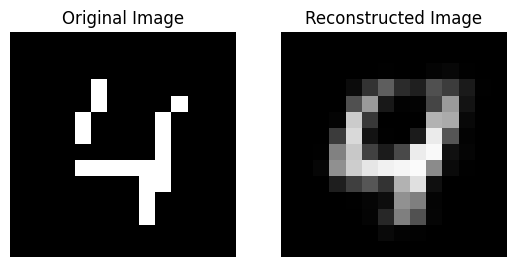

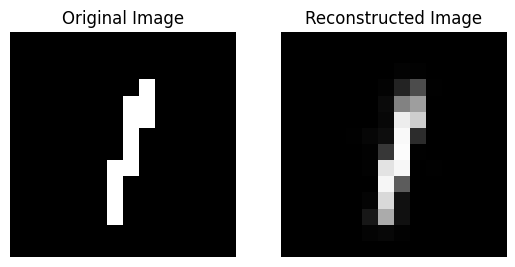

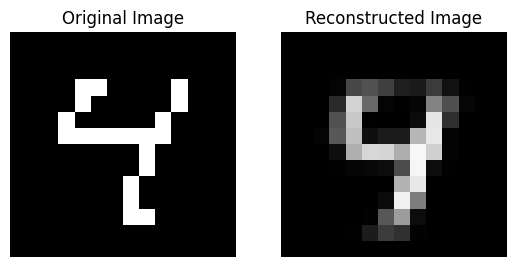

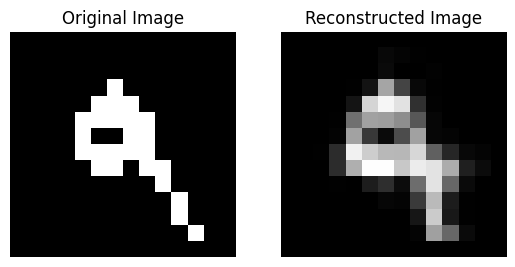

In [37]:
model.eval()
a,t = next(iter(testloader))
a = a.cuda()
recon, mu, std = model(a)
for i in range(8):
  b = recon[i].reshape((14,14))
  f, axarr = plt.subplots(1, 2)

  axarr[0].imshow(a[i].detach().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
  axarr[0].set_title("Original Image")
  axarr[0].axis("off")

  axarr[1].imshow(b.detach().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
  axarr[1].set_title("Reconstructed Image")
  axarr[1].axis("off")

  plt.show()

## VAE for Anomaly detection

In [116]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import torch.nn.functional as F

# Load the test images and labels
data_dir = "data/mnist_c/impulse_noise/"  # Replace with your actual path
test_images = np.load(f"{data_dir}/test_images.npy")
test_labels = np.load(f"{data_dir}/test_labels.npy")

# Define a custom Dataset class for MNIST-C
class CorruptedMNISTTest(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data = images
        self.targets = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert image from numpy array to PIL Image if necessary, then apply transform
        if self.transform:
            image = self.transform(image)
        
        return data, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])


In [117]:
import torchvision


In [131]:
# testset = CorruptedMNISTTest(images=test_images, labels=test_labels, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())


In [136]:

x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

In [137]:
x_val_pre.shape

(1000, 28, 28)

In [138]:
r,_,_ = x_val_pre.shape #.squeeze(3)
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

In [139]:
x_val[0]

array([[  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,  67.25,  77.5 ,  24.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , 164.25, 173.5 , 221.25, 218.75, 226.  ,
        225.  , 219.75, 154.  ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   4.25,  20.  ,  33.5 ,
         31.5 , 148.25, 146.75,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         37.75, 245.  ,  31.75,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
        173.75, 127.  ,  

In [140]:
#Binarizing images
x_val = np.where(x_val > 128, 1, 0)
x_val = x_val.astype(np.float32)

In [141]:
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=False, batch_size=100)

In [142]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

In [143]:
model_path = "weights/model_state.pth"
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()


VAE(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=8, bias=True)
  (fc22): Linear(in_features=128, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=196, bias=True)
)

In [144]:
def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, ERR, KLD

In [145]:
recon_batch_loss = []
test_loss = 0
for data, _ in testloader:
    data = data.cuda()
    recon, mu, std = model(data)
    loss, err, kld = loss_function(recon, data, mu, std)
    recon_batch_loss.append(err.item()/len(data))
    test_loss += err + kld
    
test_loss /= len(testloader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: 31.5057


In [129]:
recon_batch_loss

[32.95337890625,
 33.89517578125,
 32.1644482421875,
 30.5685107421875,
 31.98160400390625,
 34.23079345703125,
 34.24808837890625,
 32.76460693359375,
 35.9767041015625,
 33.64087646484375]

In [130]:
recon_batch_loss_noisy = recon_batch_loss

In [147]:
recon_batch_loss_clean = recon_batch_loss

In [148]:
recon_batch_loss_clean

[23.042490234375,
 22.9074658203125,
 23.3646484375,
 23.87568359375,
 25.467490234375,
 26.268603515625,
 25.25001220703125,
 23.1383251953125,
 25.132783203125,
 23.54296875]

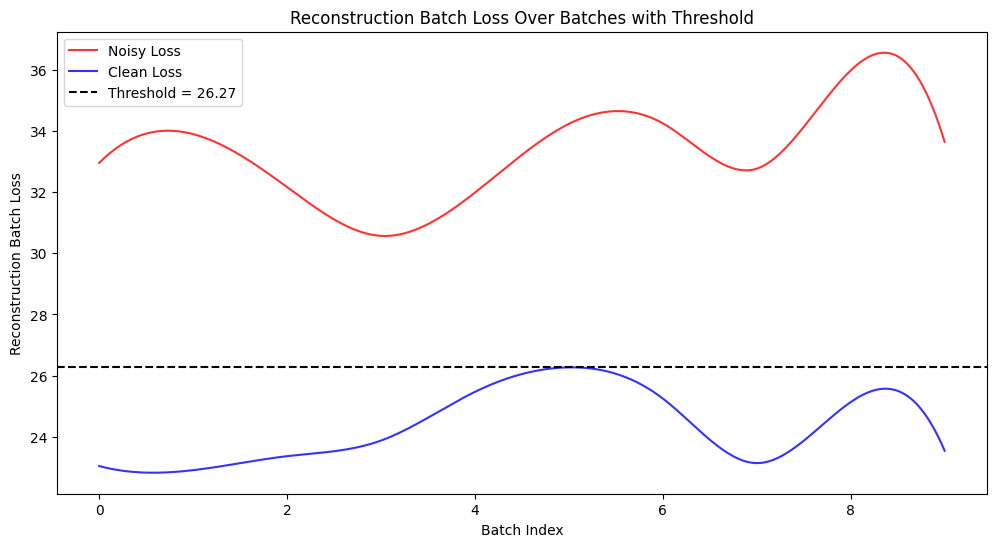

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

x_noisy = np.arange(len(recon_batch_loss_noisy))
x_clean = np.arange(len(recon_batch_loss_clean))

# Create smooth curves using interpolation
x_smooth_noisy = np.linspace(x_noisy.min(), x_noisy.max(), 300)  # 300 points for a smooth curve
x_smooth_clean = np.linspace(x_clean.min(), x_clean.max(), 300)

# Interpolate data
smooth_noisy = make_interp_spline(x_noisy, recon_batch_loss_noisy)(x_smooth_noisy)
smooth_clean = make_interp_spline(x_clean, recon_batch_loss_clean)(x_smooth_clean)

# Calculate the threshold
threshold = max(recon_batch_loss_clean)

# Plot the smooth line graphs
plt.figure(figsize=(12, 6))
plt.plot(x_smooth_noisy, smooth_noisy, label="Noisy Loss", color="red", linestyle='-', alpha=0.8)
plt.plot(x_smooth_clean, smooth_clean, label="Clean Loss", color="blue", linestyle='-', alpha=0.8)

# Add the threshold line
plt.axhline(y=threshold, color="black", linestyle="--", label=f"Threshold = {threshold:.2f}")

# Add labels and legend
plt.xlabel("Batch Index")
plt.ylabel("Reconstruction Batch Loss")
plt.title("Reconstruction Batch Loss Over Batches with Threshold")
plt.legend()

plt.show()



## VAE Latent Space Visualization using tsne


In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return z
model = VAE()
if torch.cuda.is_available():
    model.cuda()

In [8]:
# Load the saved state dictionary
model_path = "weights/model_state.pth"
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()



VAE(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=8, bias=True)
  (fc22): Linear(in_features=128, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=196, bias=True)
)

In [9]:
len(trainloader) , len(testloader) 

(313, 10)

In [10]:
color_map = {
    0: 'red',       # Class 0
    1: 'blue',      # Class 1
    2: 'green',     # Class 2
    3: 'orange',    # Class 3
    4: 'purple',    # Class 4
    5: 'brown',     # Class 5
    6: 'pink',      # Class 6
    7: 'gray',      # Class 7
    8: 'olive',     # Class 8
    9: 'cyan'       # Class 9
}


In [11]:
itrloader = iter(testloader)
first_batch= next(itrloader)
second_batch = next(itrloader)
third_batch = next(itrloader)
x_batch, y_batch = third_batch
print(y_batch)


tensor([3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7,
        1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4,
        4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0,
        1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4,
        0, 0, 2, 8])


In [34]:
# Initialize empty lists to store all x and y batches
x_combined = []
y_combined = []

# Loop over the test loader to accumulate batches
for x_batch, y_batch in trainloader:
    x_combined.append(x_batch)
    y_combined.append(y_batch)

# Concatenate all batches into a single tensor along the batch dimension (dim=0)
x_combined = torch.cat(x_combined, dim=0)
y_combined = torch.cat(y_combined, dim=0)

# Now you have a single batch with all data
# x_combined and y_combined contain all data in a single batch format


In [35]:
x_combined.shape, y_combined.shape

(torch.Size([10000, 14, 14]), torch.Size([10000]))

In [36]:
x_batch = x_combined.cuda()
output = model(x_batch)

In [37]:
output.shape

torch.Size([10000, 8])

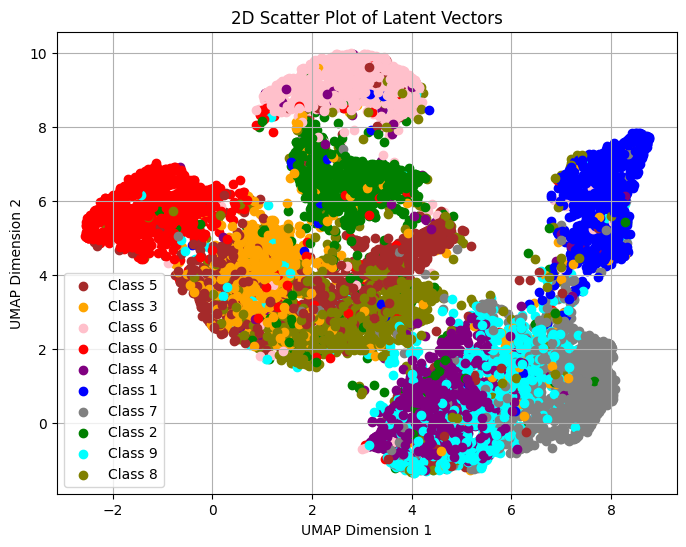

In [42]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# pca = PCA(n_components=2)
# tsne = TSNE(n_components=2)
umap_model = umap.UMAP(n_components=2)

plt.figure(figsize=(8, 6))
latent_vectors = []
class_labels = []

for latent, cls in zip(output, y_combined):
    latent_vectors.append(latent.cpu().detach().numpy())  # Convert latent to numpy array
    class_labels.append(cls.item())  # Get the class label as an integer

# Convert to numpy arrays
# print(type(latent_vectors[0][0]))
# latent_vectors = torch.Tensor(latent_vectors)
# latent_vectors = torch.stack(latent_vectors).numpy()

# Apply PCA on the latent vectors
# latent_2d = tsne.fit_transform(latent_vectors)
latent_2d = umap_model.fit_transform(latent_vectors)  # Assuming 'latent_vectors' contains your latent space data


# Plot the latent vectors, using a different color for each class
for i, label in enumerate(class_labels):
    plt.scatter(latent_2d[i, 0], latent_2d[i, 1], color=color_map[label], label=f'Class {label}', marker='o')
# Adding plot details
plt.title('2D Scatter Plot of Latent Vectors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)

# Show legend with class labels only once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Show the final plot
plt.show()



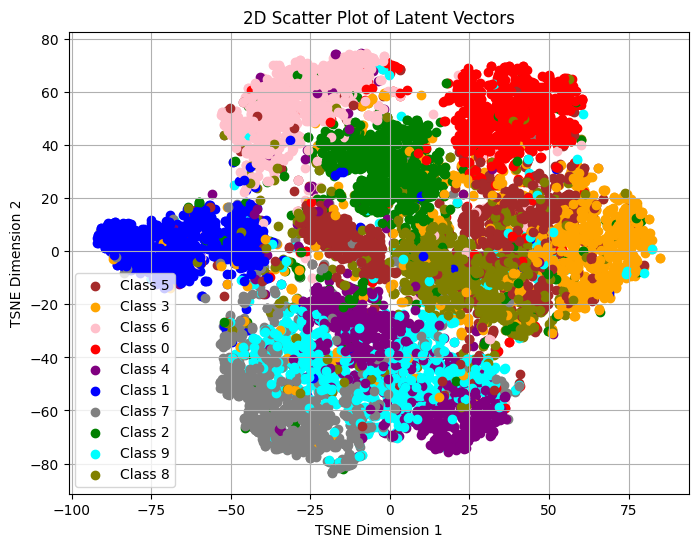

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy
# Instantiate the t-SNE model with 2 components
tsne = TSNE(n_components=2)

plt.figure(figsize=(8, 6))
latent_vectors = []
class_labels = []

# Assuming 'output' is your model output and 'y_batch' contains the corresponding labels
for latent, cls in zip(output, y_combined):
    latent_vectors.append(latent.cpu().detach())  # Convert latent to numpy array
    class_labels.append(cls.item())  # Get the class label as an integer

# Apply t-SNE on the latent vectors
latent_vectors = numpy.asarray(latent_vectors)
latent_2d = tsne.fit_transform(latent_vectors)  # 'latent_vectors' should contain your latent space data


for i, label in enumerate(class_labels):
    plt.scatter(latent_2d[i, 0], latent_2d[i, 1], color=color_map[label], label=f'Class {label}', marker='o')
# Adding plot details
plt.title('2D Scatter Plot of Latent Vectors')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.grid(True)

# Show legend with class labels only once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Show the final plot
plt.show()

